In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

In [5]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [6]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [7]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache

reference_space_key = 'annotation/ccf_2017'
resolution = 25
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest='manifest.json')
# ID 1 is the adult mouse structure graph
#tree = rspc.get_structure_tree(structure_graph_id=1) 
rsp = rspc.get_reference_space()

IP
AN
CUL
PRM
AN
SIM
DN
SIM
CUL
CENT
NOD
CUL
IP
AN
SIM
SIM
IP
CENT
AN
CENT
CUL
CUL
PYR
CUL
PFL
PFL
CUL
AN
DN
AN
SIM
SIM
CUL
AN
CUL
FN
LA
PA
BLA
CLA
BLA
CLA
LA
ENTl
CA1
SUB
ENTl
SUB
CA3
PAR
ENTm
DG
DG
ENTm
CA1
SUB
ENTl
CA1
CA3
ENTm
ENTl
DG
DG
DG
PAR
DG
APr
DG
CA3
SUB
ENTm
CA3
CA3
DG
ENTm
ENTl
DG
CA1
ProS
ENTm
ENTl
ENTl
DG
CA3
DG
DG
PAR
ENTl
ENTl
CA3
CA3
SUB
ENTl
ENTl
ENTl
ENTl
CA3
ENTm
CA1
DG
ENTm
POST
CA3
CA1
ENTl
CA1
CA1
CA3
CA3
ENTl
CA1
ENTl
CA3
ENTl
DG
ENTm
ENTm
DG
DG
DG
ENTm
ENTm
DG
CA1
DG
PRE
PAR
CA1
ENTm
ENTl
CA1
ENTl
ENTm
PAR
ENTl
CA3
CA3
DG
ENTm
CA3
ENTm
CA3
DG
CA1
CA1
CA3
ENTl
CA3
CA1
DG
POST
ENTl
CA1
ENTm
SUB
CA3
ENTl
DG
CA1
DG
ENTm
CA1
CA3
ENTl
ENTm
VMH
PVH
LHA
ARH
VMH
ARH
DMH
SCH
PVp
TU
VMH
ZI
PH
LM
PMv
SO
ARH
ZI
PMv
PVH
DMH
TU
VMH
ZI
ARH
LHA
ARH
ARH
PVHd
VMH
PMv
ZI
DMH
VMH
MPN
VMH
LM
PMv
STN
SUM
DMH
ARH
SO
ARH
PVHd
ZI
LM
AVPV
LHA
TMv
LHA
VMH
ARH
AHN
PVH
ZI
ZI
VMH
VMH
STN
ZI
SO
PVH
PSTN
PH
SCH
LHA
AHN
ZI
MPN
PVHd
LHA
SO
PVH
LHA
VMH
PVp
PVH
TU
ZI
AHN
LHA
PVp
PVp
PVH
RSPv
VIS

LGd
MD
LH
LH
RT
VPM
LD
LGv
AV
MD
SPFm
MD


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


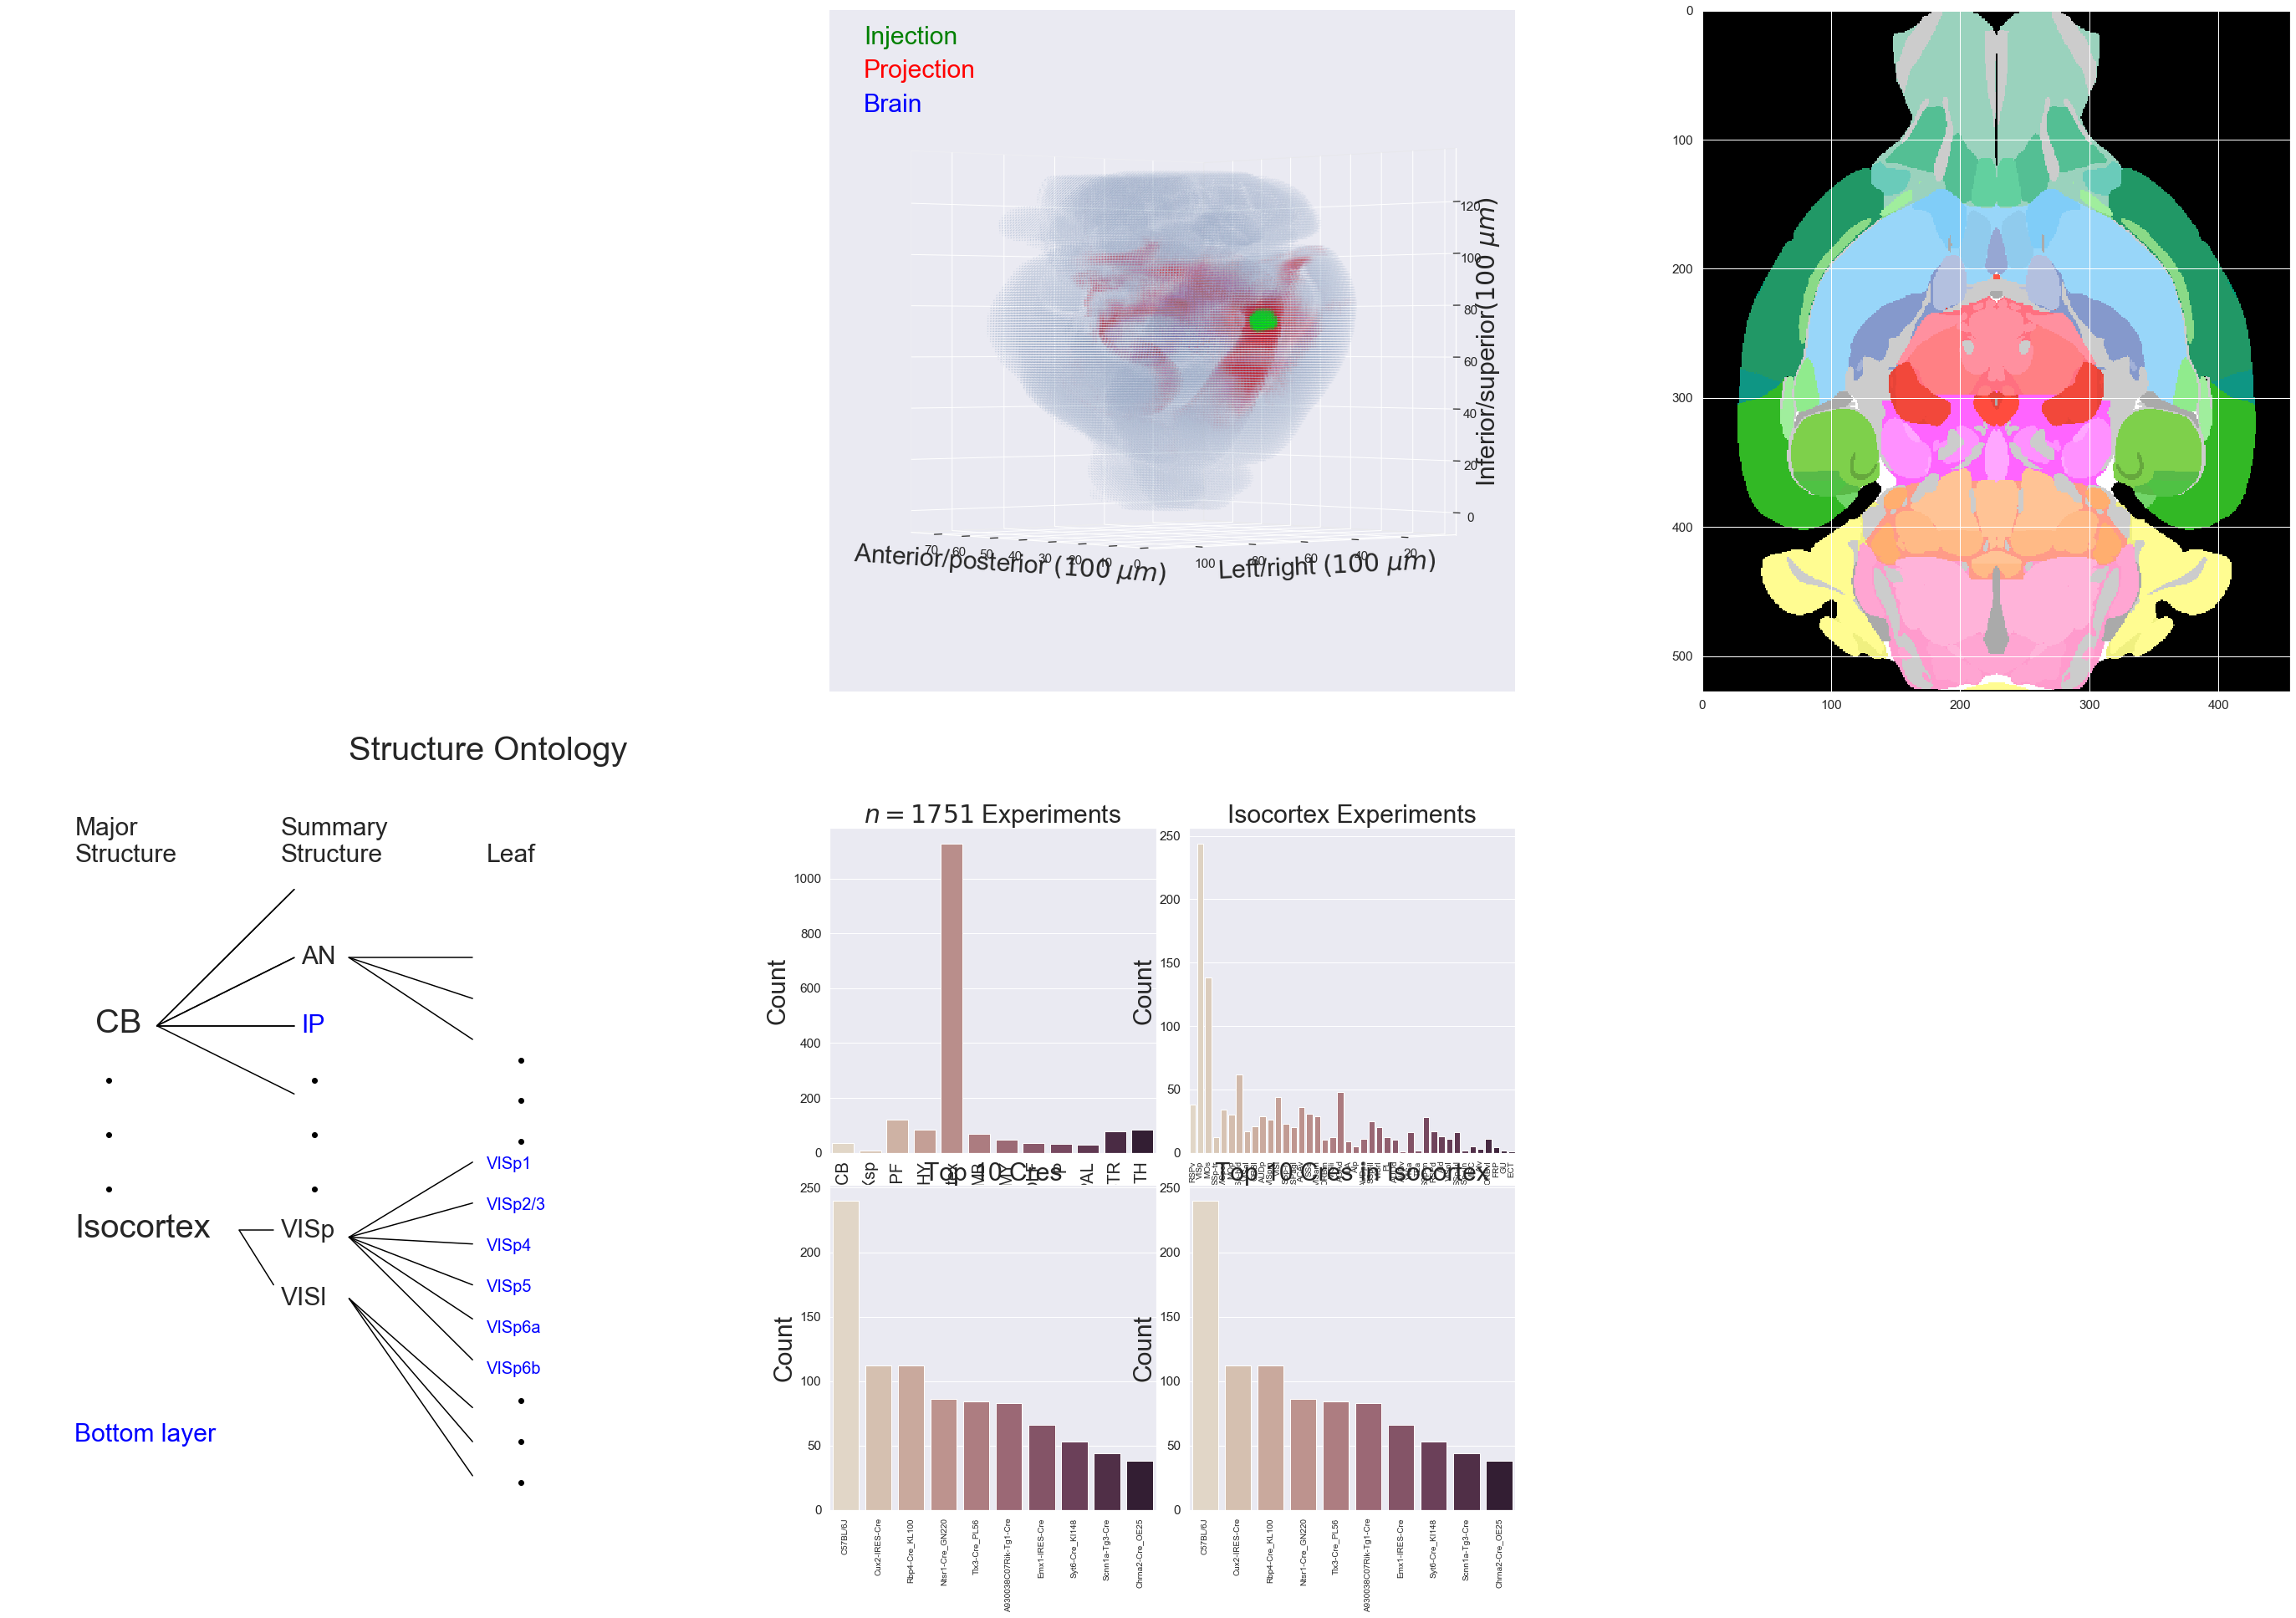

In [104]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(50, 33))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

#fig.add_subplot(ax)

i = 1
#ax = plt.Subplot(fig, outer[i], projection='3d')
ax = fig.add_subplot(2, 3, 2, projection='3d')
sid = 315
nvox = connectivity_data.structure_datas[sid].projections.shape[1]
proj_colors = np.zeros((nvox,4))
proj_colors[:,0] = 1.0
proj_colors[:, 3] = .5* connectivity_data.structure_datas[sid].projections[0] / connectivity_data.structure_datas[sid].projections[0].max()

ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], s= 2, c= proj_colors)

nvox = connectivity_data.structure_datas[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[0] / connectivity_data.structure_datas[sid].injections[0].max()

ax.scatter(connectivity_data.structure_datas[sid].injection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,0], s= 10, c= inj_colors)

ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], alpha = .05, s = .2)

ax.set_xlabel('Anterior/posterior ' + r'$(100\; \mu m)$', fontsize = 30)
ax.set_ylabel('Left/right ' + r'$(100 \;\mu m)$', fontsize = 30)
ax.set_zlabel('Inferior/superior' + r'$(100 \;\mu m)$', fontsize = 30)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(0, 140)
ax.text2D(0.05, 0.95, "Injection", transform=ax.transAxes, size = 30, c = 'green')
ax.text2D(0.05, 0.9, "Projection", transform=ax.transAxes, size = 30, c = 'red')
ax.text2D(0.05, 0.85, "Brain", transform=ax.transAxes, size = 30, c = 'blue')

#fig.add_subplot(ax)

i = 2
ax = plt.Subplot(fig, outer[i])
ax.imshow(rsp.get_slice_image(1, 5000), interpolation='none')
fig.add_subplot(ax)

i = 3

xs = np.asarray([0.15,0.15,0.15])
ys = np.asarray([.47,.55,.63])
xssum = np.asarray([0.45,0.45,0.45])
xsleaf = np.asarray([0.75,0.75,0.75])
ysleafbottom = np.asarray([.04,.1,.16])
ysleafmiddle = np.asarray([.54,.6,.66])
ax = plt.Subplot(fig, outer[i])
#outer[i]
ax.scatter(xs, ys, c = 'black')
ax.scatter(xssum, ys, c = 'black')
ax.scatter(xsleaf, ysleafbottom, c = 'black')
ax.scatter(xsleaf, ysleafmiddle, c = 'black')

ax.set_xlim(0,1.)
ax.set_ylim (0,1.)
ax.text(0.1,.95,r"Major" + '\n' + 'Structure', size = 30)
ax.text(0.4,.95,r"Summary" + '\n' + 'Structure', size = 30)
ax.text(0.7,.95,'Leaf', size = 30)

ax.text(0.1,.4,'Isocortex', size = 40)
ax.text(0.13,.7,'CB', size = 40)

ax.text(0.43,.7,'IP', size = 30, c= 'blue')
ax.text(0.43,.8,'AN', size = 30)

ax.text(0.4,.3,'VISl', size = 30)


ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')


ax.text(0.4,.4,'VISp', size = 30)
ax.text(0.7,.5,'VISp1', size = 20, c= 'blue')
ax.text(0.7,.44,'VISp2/3', size = 20, c= 'blue')
ax.text(0.7,.38,'VISp4', size = 20, c= 'blue')
ax.text(0.7,.32,'VISp5', size = 20, c= 'blue')
ax.text(0.7,.26,'VISp6a', size = 20, c= 'blue')
ax.text(0.7,.2,'VISp6b', size = 20, c= 'blue')

ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .61]), c= 'black')

ax.plot(list([0.34,0.39]) , list([.41, .41]), c= 'black')
ax.plot(list([0.34,0.39]) , list([.41, .33]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.4, .22]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .28]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .33]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .39]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .45]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .51]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.81, .69]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .75]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .81]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.31, .05]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .1]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .15]), c= 'black')

ax.text(0.1,.1, 'Bottom layer',c=  'blue', fontsize = 30)
ax.text(0.5,1.1, 'Structure Ontology',fontsize = 40)
ax.set_axis_off()
fig.add_subplot(ax)
#fig.tight_layout()

i = 4
expd = pd.DataFrame([])
for sid in major_structure_ids:
    nexp = leafs[sid].shape[0]
    #print(nexp)
    for i in range(nexp):
        print(ia_map[connectivity_data.structure_datas[sid].summary_structures[i]])
        expd = expd.append(pd.DataFrame([ia_map[sid],
                                         ia_map[connectivity_data.structure_datas[sid].summary_structures[i]], 
                                         connectivity_data.creline[sid][i]]).transpose())

isoind = np.where(np.asarray(expd[0]) == 'Isocortex')[0]
expd_iso = expd.iloc[isoind]
i = 4
inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=outer[i], wspace=0.1, hspace=0.1)
ax1 = plt.Subplot(fig, inner[0])
#ax1 = fig.add_subplot(2,2,1)
sns.catplot(x=0, kind="count", palette="ch:.25", data=expd, ax = ax1)
ax1.set_title(r'$n = 1751$ Experiments', fontsize = 30)
ax1.set_ylabel('Count', fontsize = 30)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 20)
ax1.set_xlabel('', fontsize = 30)
#plt.close(2)
fig.add_subplot(ax1)
#fig.tight_layout()
#axes[0,1].set_axis_off()
#ax2 = fig.add_subplot(2,2,2)
ax2 = plt.Subplot(fig, inner[1])
sns.catplot(x=1, kind="count", palette="ch:.25", data=expd_iso, ax = ax2)
ax2.set_title('Isocortex Experiments', fontsize = 30)
ax2.set_ylabel('Count', fontsize = 30)
ax2.set_xlabel('', fontsize = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize = 10)
fig.add_subplot(ax2)
#fig.tight_layout()
#         axes[1,0].set_axis_off()
#         ax3 = fig.add_subplot(2,2,3)
ax3 = plt.Subplot(fig, inner[2])
sns.catplot(x=2, kind="count", palette="ch:.25", data=expd, ax = ax3,order=expd[2].value_counts().iloc[:10].index)
ax3.set_title('Top 10 Cres', fontsize = 30)
ax3.set_ylabel('Count', fontsize = 30)
ax3.set_xlabel('', fontsize = 30)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, fontsize = 10)
fig.add_subplot(ax3)
#fig.tight_layout()
ax4 = plt.Subplot(fig, inner[3])
#         axes[1,1].set_axis_off()
#ax4 = fig.add_subplot(2,2,4)
sns.catplot(x=2, kind="count", palette="ch:.25", data=expd, ax = ax4,order=expd_iso[2].value_counts().iloc[:10].index)
ax4.set_title('Top 10 Cres in Isocortex', fontsize = 30)
ax4.set_ylabel('Count', fontsize = 30)
ax4.set_xlabel('', fontsize = 30)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, fontsize = 10)
fig.add_subplot(ax4)

#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

IP
AN
CUL
PRM
AN
SIM
DN
SIM
CUL
CENT
NOD
CUL
IP
AN
SIM
SIM
IP
CENT
AN
CENT
CUL
CUL
PYR
CUL
PFL
PFL
CUL
AN
DN
AN
SIM
SIM
CUL
AN
CUL
FN
LA
PA
BLA
CLA
BLA
CLA
LA
ENTl
CA1
SUB
ENTl
SUB
CA3
PAR
ENTm
DG
DG
ENTm
CA1
SUB
ENTl
CA1
CA3
ENTm
ENTl
DG
DG
DG
PAR
DG
APr
DG
CA3
SUB
ENTm
CA3
CA3
DG
ENTm
ENTl
DG
CA1
ProS
ENTm
ENTl
ENTl
DG
CA3
DG
DG
PAR
ENTl
ENTl
CA3
CA3
SUB
ENTl
ENTl
ENTl
ENTl
CA3
ENTm
CA1
DG
ENTm
POST
CA3
CA1
ENTl
CA1
CA1
CA3
CA3
ENTl
CA1
ENTl
CA3
ENTl
DG
ENTm
ENTm
DG
DG
DG
ENTm
ENTm
DG
CA1
DG
PRE
PAR
CA1
ENTm
ENTl
CA1
ENTl
ENTm
PAR
ENTl
CA3
CA3
DG
ENTm
CA3
ENTm
CA3
DG
CA1
CA1
CA3
ENTl
CA3
CA1
DG
POST
ENTl
CA1
ENTm
SUB
CA3
ENTl
DG
CA1
DG
ENTm
CA1
CA3
ENTl
ENTm
VMH
PVH
LHA
ARH
VMH
ARH
DMH
SCH
PVp
TU
VMH
ZI
PH
LM
PMv
SO
ARH
ZI
PMv
PVH
DMH
TU
VMH
ZI
ARH
LHA
ARH
ARH
PVHd
VMH
PMv
ZI
DMH
VMH
MPN
VMH
LM
PMv
STN
SUM
DMH
ARH
SO
ARH
PVHd
ZI
LM
AVPV
LHA
TMv
LHA
VMH
ARH
AHN
PVH
ZI
ZI
VMH
VMH
STN
ZI
SO
PVH
PSTN
PH
SCH
LHA
AHN
ZI
MPN
PVHd
LHA
SO
PVH
LHA
VMH
PVp
PVH
TU
ZI
AHN
LHA
PVp
PVp
PVH
RSPv
VIS

PVT
MD
MD
LGd
MD
LH
LH
RT
VPM
LD
LGv
AV
MD
SPFm
MD


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


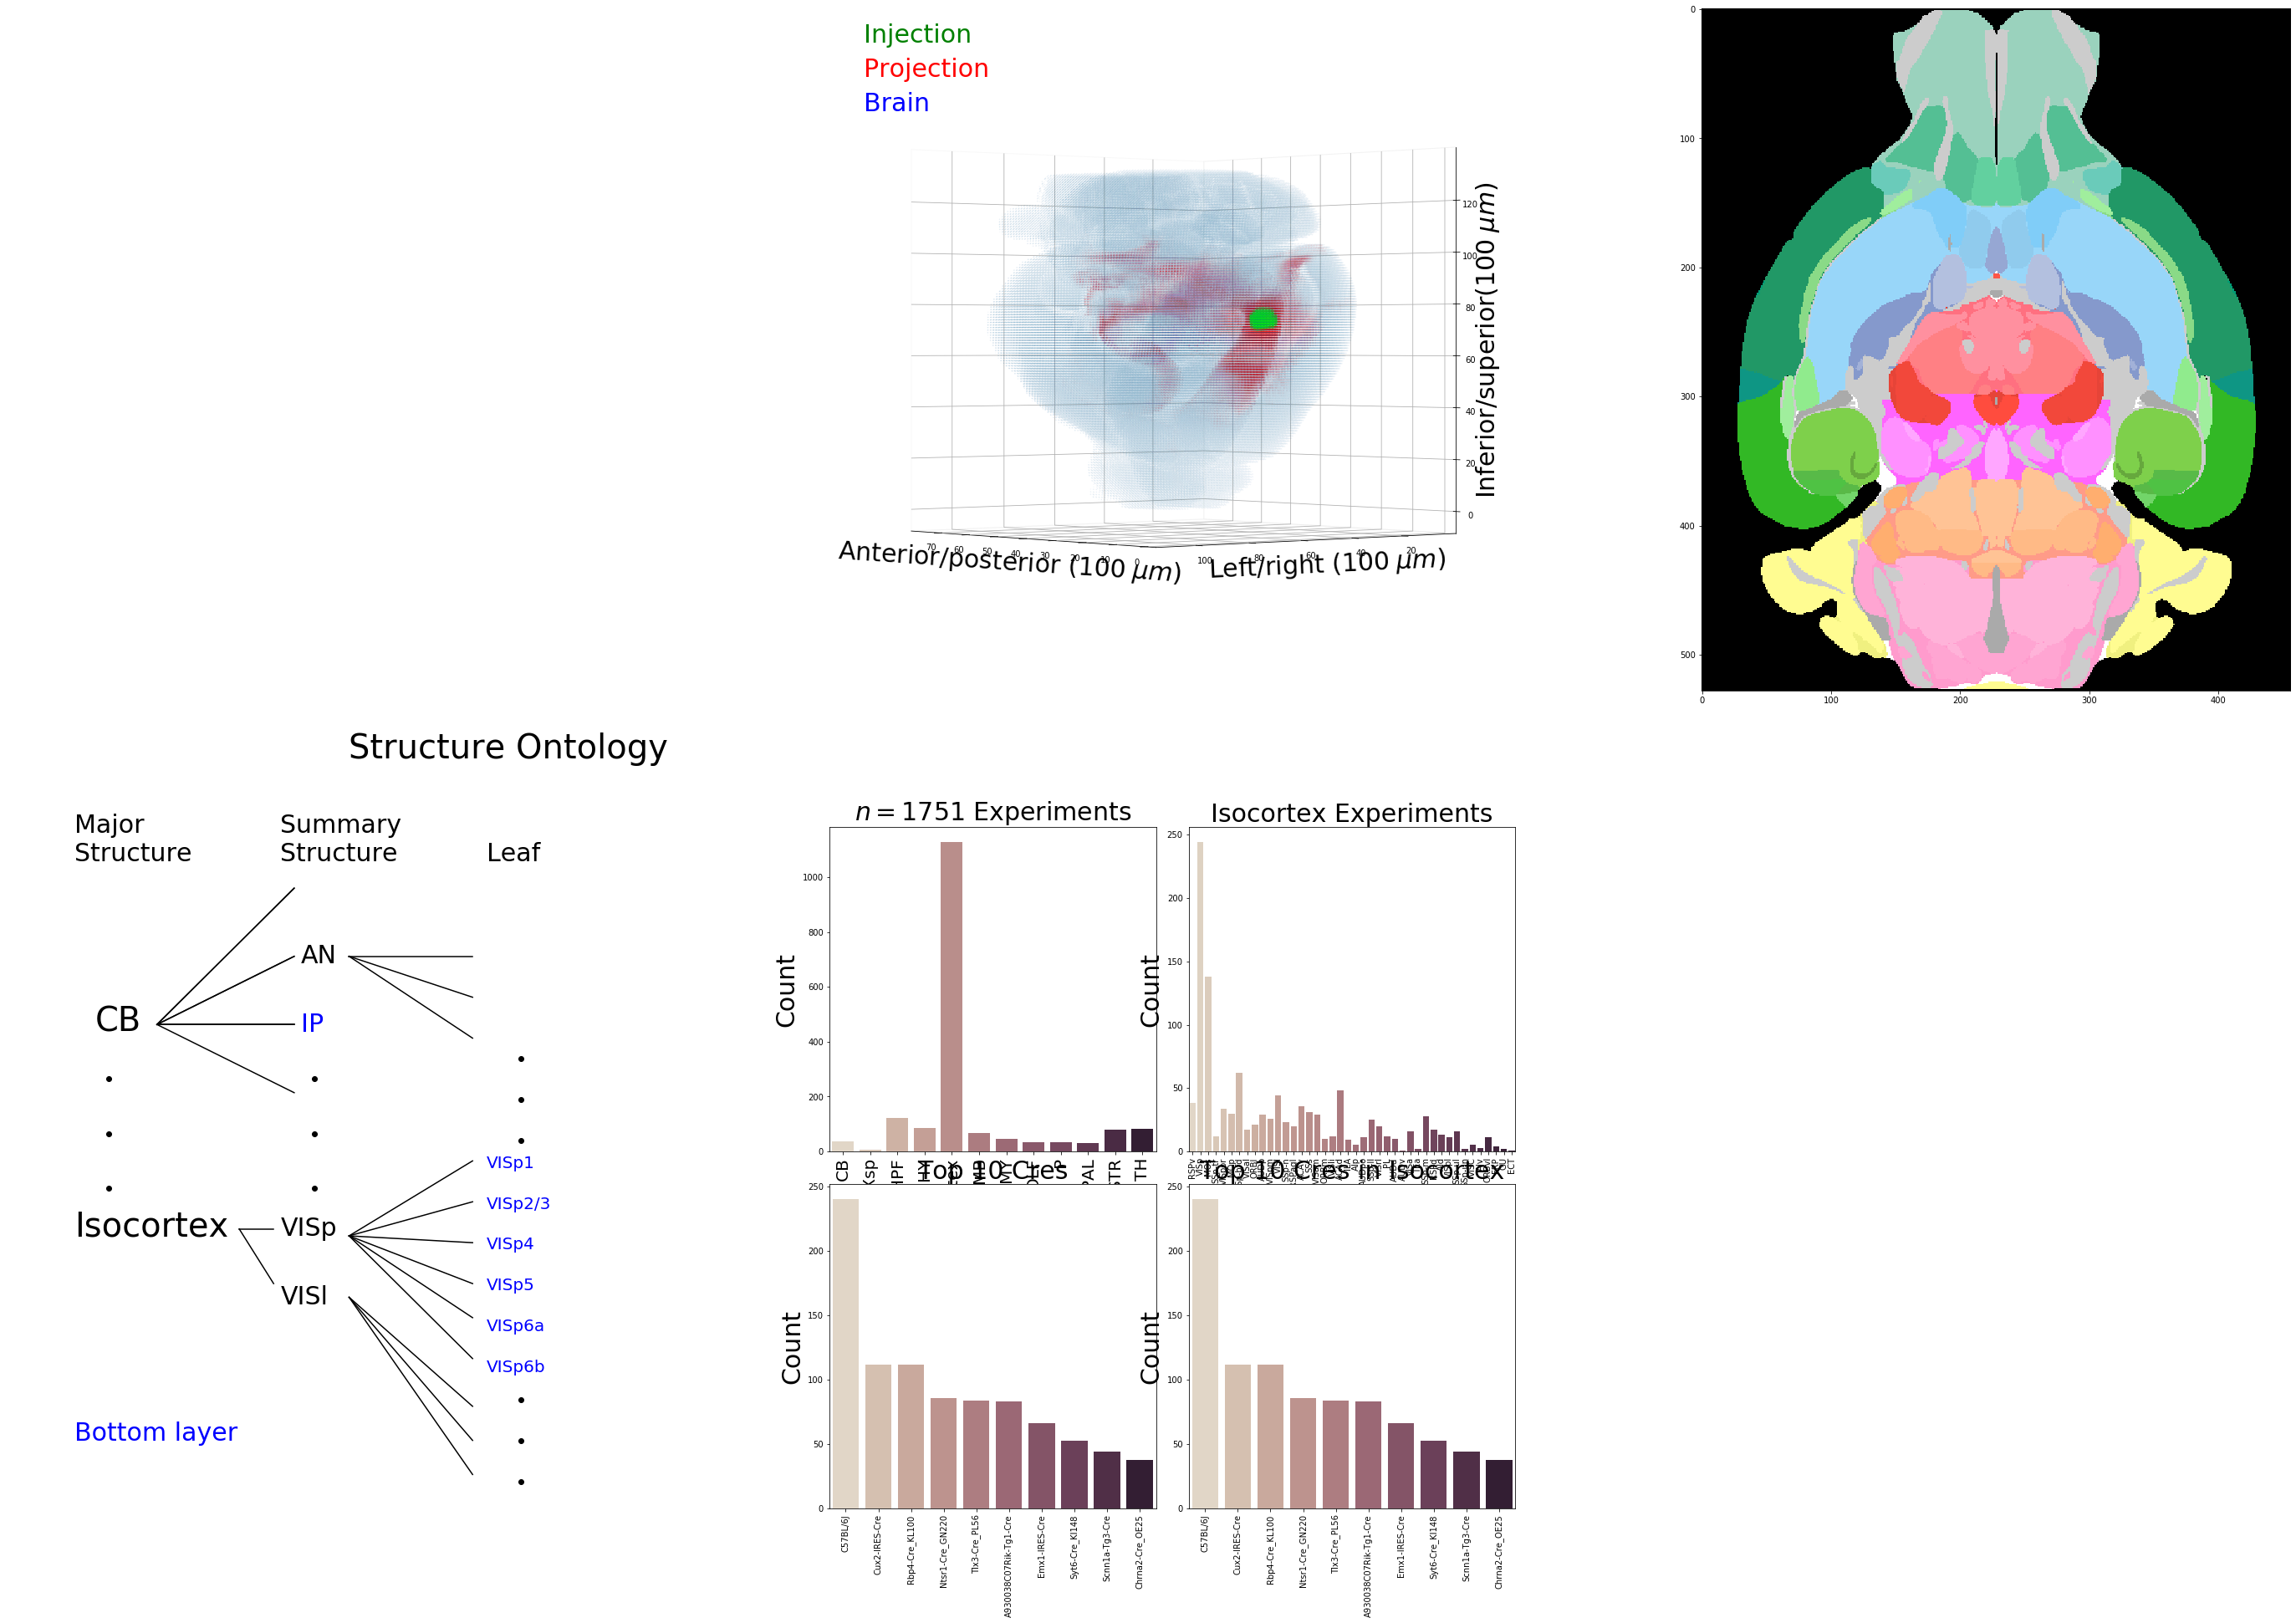

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(50, 33))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

#fig.add_subplot(ax)

i = 1
#ax = plt.Subplot(fig, outer[i], projection='3d')
ax = fig.add_subplot(2, 3, 2, projection='3d')
sid = 315
nvox = connectivity_data.structure_datas[sid].projections.shape[1]
proj_colors = np.zeros((nvox,4))
proj_colors[:,0] = 1.0
proj_colors[:, 3] = .5* connectivity_data.structure_datas[sid].projections[0] / connectivity_data.structure_datas[sid].projections[0].max()

ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], s= 2, c= proj_colors)

nvox = connectivity_data.structure_datas[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[0] / connectivity_data.structure_datas[sid].injections[0].max()

ax.scatter(connectivity_data.structure_datas[sid].injection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,0], s= 10, c= inj_colors)

ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], alpha = .05, s = .2)

ax.set_xlabel('Anterior/posterior ' + r'$(100\; \mu m)$', fontsize = 30)
ax.set_ylabel('Left/right ' + r'$(100 \;\mu m)$', fontsize = 30)
ax.set_zlabel('Inferior/superior' + r'$(100 \;\mu m)$', fontsize = 30)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(0, 140)
ax.text2D(0.05, 0.95, "Injection", transform=ax.transAxes, size = 30, c = 'green')
ax.text2D(0.05, 0.9, "Projection", transform=ax.transAxes, size = 30, c = 'red')
ax.text2D(0.05, 0.85, "Brain", transform=ax.transAxes, size = 30, c = 'blue')

#fig.add_subplot(ax)

i = 2
ax = plt.Subplot(fig, outer[i])
ax.imshow(rsp.get_slice_image(1, 5000), interpolation='none')
fig.add_subplot(ax)

i = 3

xs = np.asarray([0.15,0.15,0.15])
ys = np.asarray([.47,.55,.63])
xssum = np.asarray([0.45,0.45,0.45])
xsleaf = np.asarray([0.75,0.75,0.75])
ysleafbottom = np.asarray([.04,.1,.16])
ysleafmiddle = np.asarray([.54,.6,.66])
ax = plt.Subplot(fig, outer[i])
#outer[i]
ax.scatter(xs, ys, c = 'black')
ax.scatter(xssum, ys, c = 'black')
ax.scatter(xsleaf, ysleafbottom, c = 'black')
ax.scatter(xsleaf, ysleafmiddle, c = 'black')

ax.set_xlim(0,1.)
ax.set_ylim (0,1.)
ax.text(0.1,.95,r"Major" + '\n' + 'Structure', size = 30)
ax.text(0.4,.95,r"Summary" + '\n' + 'Structure', size = 30)
ax.text(0.7,.95,'Leaf', size = 30)

ax.text(0.1,.4,'Isocortex', size = 40)
ax.text(0.13,.7,'CB', size = 40)

ax.text(0.43,.7,'IP', size = 30, c= 'blue')
ax.text(0.43,.8,'AN', size = 30)

ax.text(0.4,.3,'VISl', size = 30)


ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')


ax.text(0.4,.4,'VISp', size = 30)
ax.text(0.7,.5,'VISp1', size = 20, c= 'blue')
ax.text(0.7,.44,'VISp2/3', size = 20, c= 'blue')
ax.text(0.7,.38,'VISp4', size = 20, c= 'blue')
ax.text(0.7,.32,'VISp5', size = 20, c= 'blue')
ax.text(0.7,.26,'VISp6a', size = 20, c= 'blue')
ax.text(0.7,.2,'VISp6b', size = 20, c= 'blue')

ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .61]), c= 'black')

ax.plot(list([0.34,0.39]) , list([.41, .41]), c= 'black')
ax.plot(list([0.34,0.39]) , list([.41, .33]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.4, .22]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .28]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .33]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .39]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .45]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .51]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.81, .69]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .75]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .81]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.31, .05]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .1]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .15]), c= 'black')

ax.text(0.1,.1, 'Bottom layer',c=  'blue', fontsize = 30)
ax.text(0.5,1.1, 'Structure Ontology',fontsize = 40)
ax.set_axis_off()
fig.add_subplot(ax)
#fig.tight_layout()

i = 4
expd = pd.DataFrame([])
for sid in major_structure_ids:
    nexp = leafs[sid].shape[0]
    #print(nexp)
    for i in range(nexp):
        print(ia_map[connectivity_data.structure_datas[sid].summary_structures[i]])
        expd = expd.append(pd.DataFrame([ia_map[sid],
                                         ia_map[connectivity_data.structure_datas[sid].summary_structures[i]], 
                                         connectivity_data.creline[sid][i]]).transpose())

isoind = np.where(np.asarray(expd[0]) == 'Isocortex')[0]
expd_iso = expd.iloc[isoind]
i = 4
inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=outer[i], wspace=0.1, hspace=0.1)
ax1 = plt.Subplot(fig, inner[0])
#ax1 = fig.add_subplot(2,2,1)
sns.catplot(x=0, kind="count", palette="ch:.25", data=expd, ax = ax1)
ax1.set_title(r'$n = 1751$ Experiments', fontsize = 30)
ax1.set_ylabel('Count', fontsize = 30)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 20)
ax1.set_xlabel('', fontsize = 30)
#plt.close(2)
fig.add_subplot(ax1)
#fig.tight_layout()
#axes[0,1].set_axis_off()
#ax2 = fig.add_subplot(2,2,2)
ax2 = plt.Subplot(fig, inner[1])
sns.catplot(x=1, kind="count", palette="ch:.25", data=expd_iso, ax = ax2)
ax2.set_title('Isocortex Experiments', fontsize = 30)
ax2.set_ylabel('Count', fontsize = 30)
ax2.set_xlabel('', fontsize = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize = 10)
fig.add_subplot(ax2)
#fig.tight_layout()
#         axes[1,0].set_axis_off()
#         ax3 = fig.add_subplot(2,2,3)
ax3 = plt.Subplot(fig, inner[2])
ax3.set_ylabel('Count', fontsize = 30)
ax3.set_xlabel('', fontsize = 30)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, fontsize = 10)
fig.add_subplot(ax3)
#fig.tight_layout()
ax4 = plt.Subplot(fig, inner[3])
#         axes[1,1].set_axis_off()
#ax4 = fig.add_subplot(2,2,4)
sns.catplot(x=2, kind="count", palette="ch:.25", data=expd, ax = ax4,order=expd_iso[2].value_counts().iloc[:10].index)
ax4.set_title('Top 10 Cres in Isocortex', fontsize = 30)
ax4.set_ylabel('Count', fontsize = 30)
ax4.set_xlabel('', fontsize = 30)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, fontsize = 10)
fig.add_subplot(ax4)

#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

In [2]:
sns.catplot(x=1, kind="count", palette="ch:.25", data=expd_iso)


NameError: name 'sns' is not defined

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:203: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


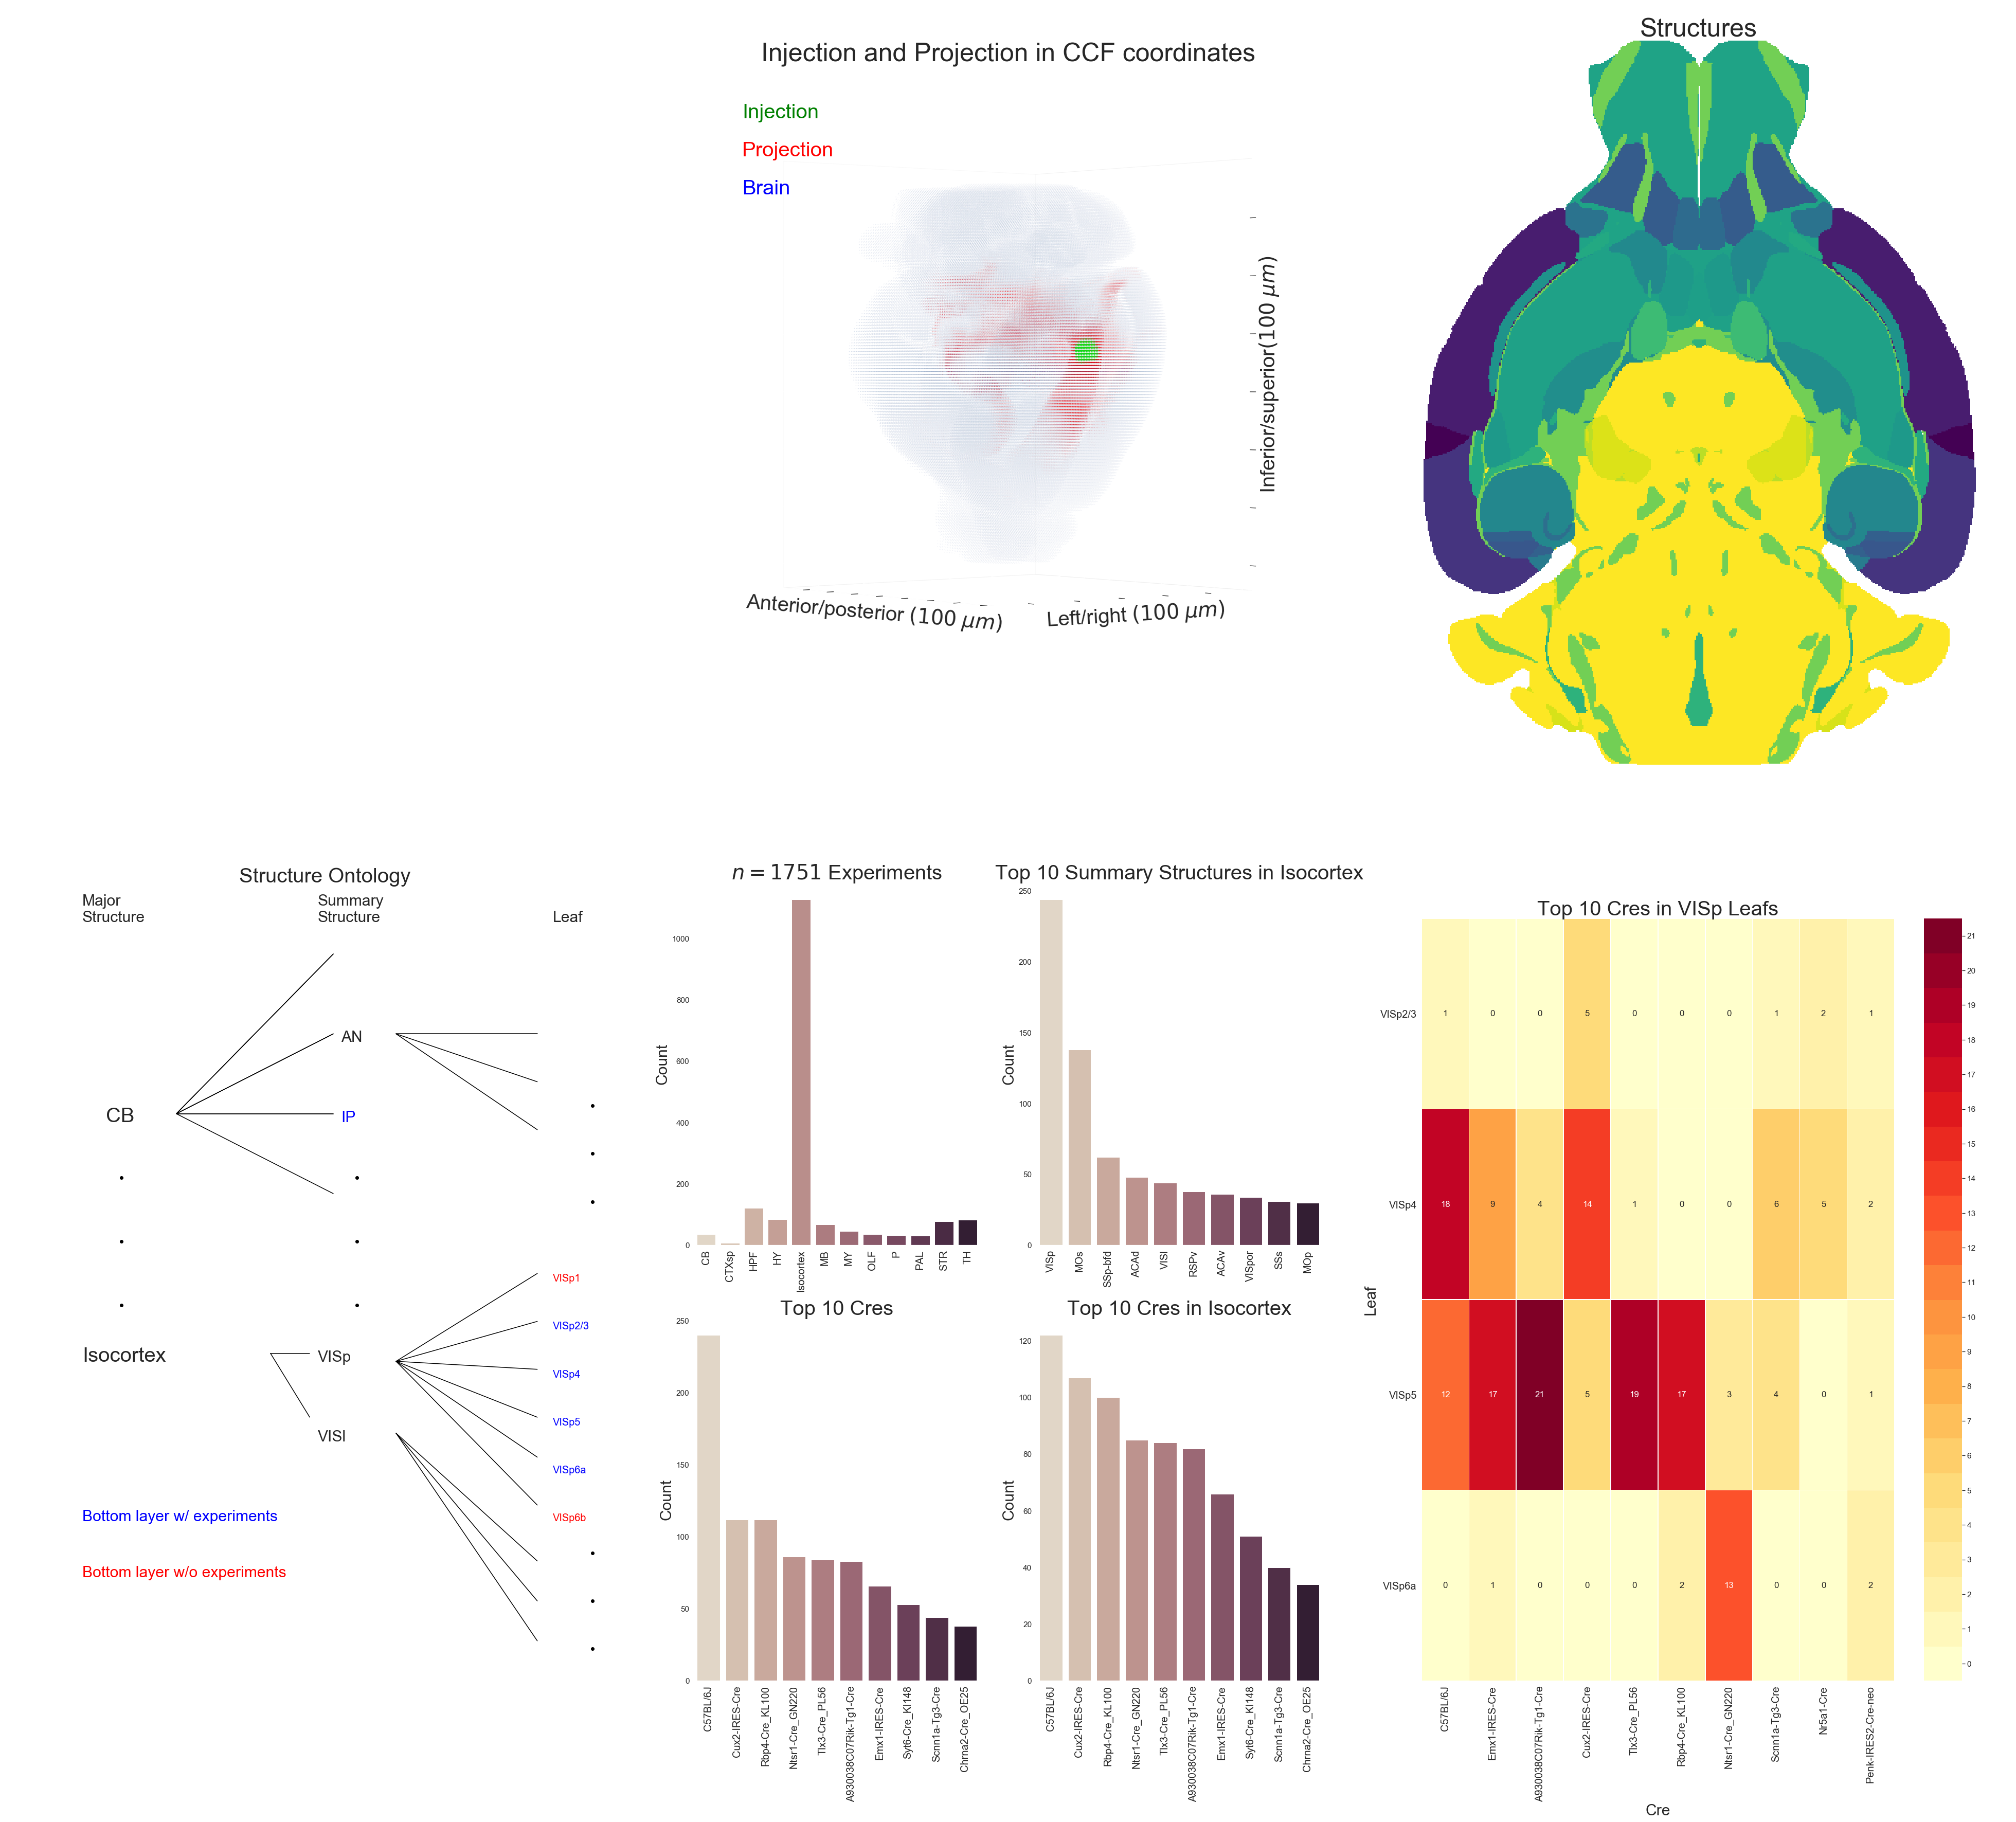

In [109]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(70, 60))
outer = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.1)

#fig.add_subplot(ax)

i = 1
#ax = plt.Subplot(fig, outer[i], projection='3d')
ax = fig.add_subplot(2, 3, 2, projection='3d')
sid = 315
nvox = connectivity_data.structure_datas[sid].projections.shape[1]
proj_colors = np.zeros((nvox,4))
proj_colors[:,0] = 1.0
proj_colors[:, 3] = .5* connectivity_data.structure_datas[sid].projections[0] / connectivity_data.structure_datas[sid].projections[0].max()

ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], s= 2, c= proj_colors)

nvox = connectivity_data.structure_datas[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[0] / connectivity_data.structure_datas[sid].injections[0].max()

ax.scatter(connectivity_data.structure_datas[sid].injection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,0], s= 10, c= inj_colors)

ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], alpha = .05, s = .2)

ax.set_xlabel('Anterior/posterior ' + r'$(100\; \mu m)$', fontsize = 40)
ax.set_ylabel('Left/right ' + r'$(100 \;\mu m)$', fontsize = 40)
ax.set_zlabel('Inferior/superior' + r'$(100 \;\mu m)$', fontsize = 40)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize = 20)
ax.set_yticklabels(ax.get_yticklabels(),  fontsize = 20)
ax.set_zticklabels(ax.get_zticklabels(),  fontsize = 20)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(0, 140)
ax.set_facecolor('white')
ax.text2D(0.05, 0.85, "Injection", transform=ax.transAxes, size = 40, c = 'green')
ax.text2D(0.05, 0.8, "Projection", transform=ax.transAxes, size = 40, c = 'red')
ax.text2D(0.05, 0.75, "Brain", transform=ax.transAxes, size = 40, c = 'blue')
ax.set_title('Injection and Projection in CCF coordinates', size = 50)
#fig.add_subplot(ax)
i = 2
ax = plt.Subplot(fig, outer[i])
si = rsp.get_slice_image(1, 5000)[:,:,0]
si = np.ma.masked_where(si == 0., si)
ax.imshow(si, cmap = 'viridis')
ax.set_axis_off()
ax.set_title('Structures', fontsize = 50)
fig.add_subplot(ax)

i = 3

xs = np.asarray([0.15,0.15,0.15])
ys = np.asarray([.47,.55,.63])
xssum = np.asarray([0.45,0.45,0.45])
xsleaf = np.asarray([0.75,0.75,0.75])
ysleafbottom = np.asarray([.04,.1,.16])
ysleafmiddle = np.asarray([.6,.66,.72])
ax = plt.Subplot(fig, outer[i])
#outer[i]
ax.scatter(xs, ys, c = 'black')
ax.scatter(xssum, ys, c = 'black')
ax.scatter(xsleaf, ysleafbottom, c = 'black')
ax.scatter(xsleaf, ysleafmiddle, c = 'black')

ax.set_xlim(0,1.)
ax.set_ylim (0,1.)
ax.text(0.1,.95,r"Major" + '\n' + 'Structure', size = 30)
ax.text(0.4,.95,r"Summary" + '\n' + 'Structure', size = 30)
ax.text(0.7,.95,'Leaf', size = 30)

ax.text(0.1,.4,'Isocortex', size = 40)
ax.text(0.13,.7,'CB', size = 40)

ax.text(0.43,.7,'IP', size = 30, c= 'blue')
ax.text(0.43,.8,'AN', size = 30)

ax.text(0.4,.3,'VISl', size = 30)


ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')


ax.text(0.4,.4,'VISp', size = 30)
ax.text(0.7,.5,'VISp1', size = 20, c= 'red')
ax.text(0.7,.44,'VISp2/3', size = 20, c= 'blue')
ax.text(0.7,.38,'VISp4', size = 20, c= 'blue')
ax.text(0.7,.32,'VISp5', size = 20, c= 'blue')
ax.text(0.7,.26,'VISp6a', size = 20, c= 'blue')
ax.text(0.7,.2,'VISp6b', size = 20, c= 'red')

ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .61]), c= 'black')

ax.plot(list([0.34,0.39]) , list([.41, .41]), c= 'black')
ax.plot(list([0.34,0.39]) , list([.41, .33]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.4, .22]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .28]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .33]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .39]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .45]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .51]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.81, .69]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .75]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .81]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.31, .05]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .1]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .15]), c= 'black')

ax.text(0.1,.2, 'Bottom layer w/ experiments',c=  'blue', fontsize = 30)
ax.text(0.1,.13, 'Bottom layer w/o experiments',c=  'red', fontsize = 30)
ax.text(0.3,1., 'Structure Ontology',fontsize = 40)
ax.set_axis_off()
ax.set_xlim(0,.8)
fig.add_subplot(ax)

i = 4
inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=outer[i], wspace=.2, hspace=0.2)

ax1 = plt.Subplot(fig, inner[0], aspect='auto')
sns.catplot(x=0, kind="count", palette="ch:.25", data=expd, ax = ax1)
ax1.set_title(r'$n = 1751$ Experiments', fontsize = 40)
ax1.set_ylabel('Count', fontsize = 30)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 20)
ax1.set_xlabel('', fontsize = 30)
ax1.set_facecolor('white')
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax1, aspect='auto')


ax2 = plt.Subplot(fig, inner[1], aspect='auto')
#sns.catplot(x=1, kind="count", palette="ch:.25", data=expd_iso, ax = ax2)
sns.catplot(x=1, kind="count", palette="ch:.25", data=expd_iso, ax = ax2,order=expd_iso[1].value_counts().iloc[:10].index)
ax2.set_title('Top 10 Summary Structures in Isocortex', fontsize = 40)
ax2.set_ylabel('Count', fontsize = 30)
ax2.set_xlabel('', fontsize = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize = 20)
ax2.set_facecolor('white')
#ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax2, aspect='auto')

ax3 = plt.Subplot(fig, inner[2], aspect='auto')
sns.catplot(x=2, kind="count", palette="ch:.25", data=expd, ax = ax3,order=expd[2].value_counts().iloc[:10].index)
ax3.set_title('Top 10 Cres', fontsize = 40)
ax3.set_ylabel('Count', fontsize = 30)
ax3.set_xlabel('', fontsize = 30)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, fontsize = 20)
ax3.set_facecolor('white')
#ax3.set_yticklabels(ax3.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax3, aspect='auto')


ax4 = plt.Subplot(fig, inner[3], aspect='auto')
sns.catplot(x=2, kind="count", palette="ch:.25", data=expd_iso, ax = ax4,order=expd_iso[2].value_counts().iloc[:10].index)
ax4.set_title('Top 10 Cres in Isocortex', fontsize = 40)
ax4.set_ylabel('Count', fontsize = 30)
ax4.set_xlabel('', fontsize = 30)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, fontsize = 20)
ax4.set_facecolor('white')
#ax4.set_yticklabels(ax4.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax4, aspect='auto')
#fig.subplots_adjust(wspace=1.)

i = 5
ax = fig.add_subplot(2, 3, 6)
# sns.heatmap(revels, annot=True, linewidths=0.4, cmap=cmap,
#         cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)

sns.set(font_scale=1.4)
sns.heatmap(rts, annot=True, linewidths=0.4, cmap=cmap,
        cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 20)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize = 20)
ax.set_xlabel('Cre', fontsize = 30)
ax.set_ylabel('Leaf', fontsize = 30)
ax.set_title('Top 10 Cres in VISp Leafs', fontsize = 40)

#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


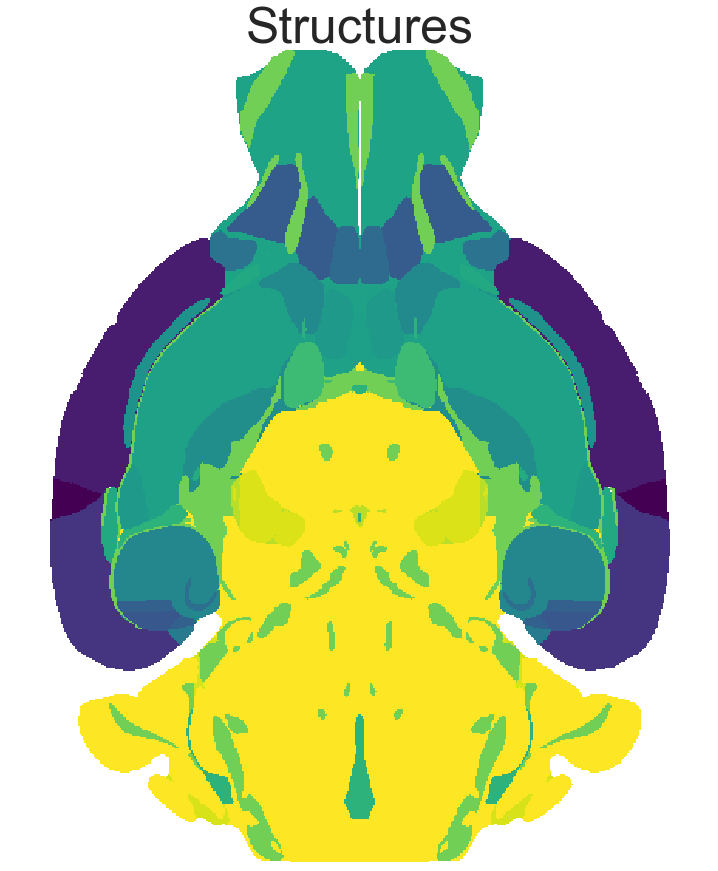

In [100]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(50, 33))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

i = 2
ax = plt.Subplot(fig, outer[i])
si = rsp.get_slice_image(1, 5000)[:,:,0]
si = np.ma.masked_where(si == 0., si)
ax.imshow(si, cmap = 'viridis')
ax.set_axis_off()
ax.set_title('Structures', fontsize = 50)
fig.add_subplot(ax)

#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


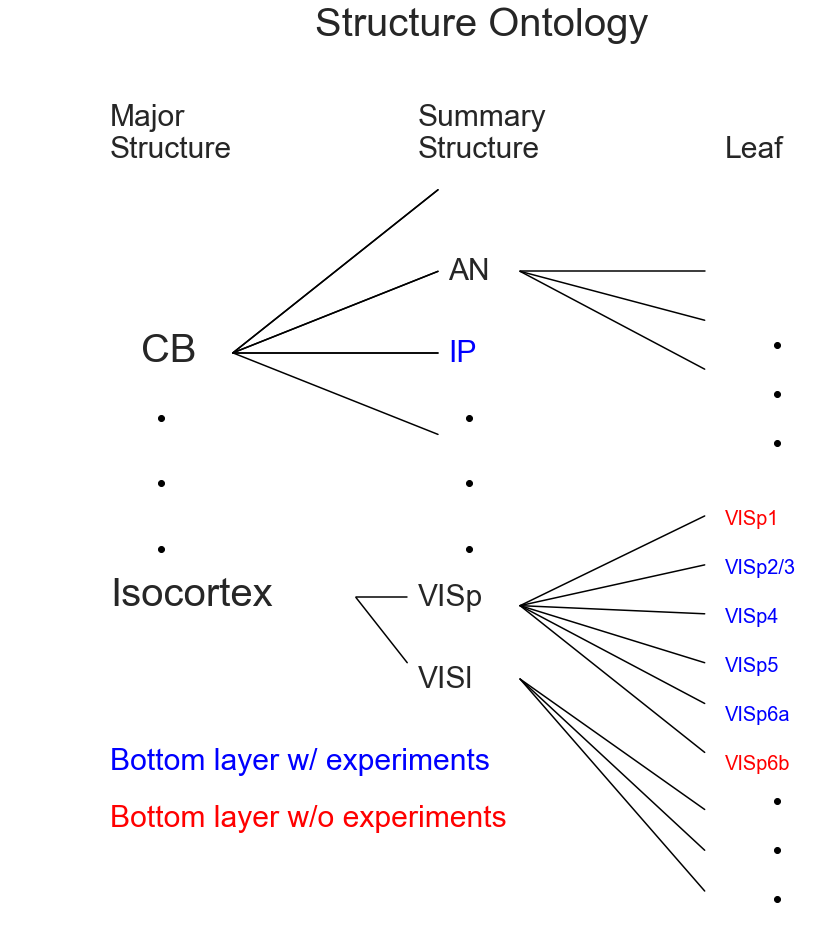

In [86]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(50, 33))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

#fig.add_subplot(ax)

i = 3

xs = np.asarray([0.15,0.15,0.15])
ys = np.asarray([.47,.55,.63])
xssum = np.asarray([0.45,0.45,0.45])
xsleaf = np.asarray([0.75,0.75,0.75])
ysleafbottom = np.asarray([.04,.1,.16])
ysleafmiddle = np.asarray([.6,.66,.72])
ax = plt.Subplot(fig, outer[i])
#outer[i]
ax.scatter(xs, ys, c = 'black')
ax.scatter(xssum, ys, c = 'black')
ax.scatter(xsleaf, ysleafbottom, c = 'black')
ax.scatter(xsleaf, ysleafmiddle, c = 'black')

ax.set_xlim(0,1.)
ax.set_ylim (0,1.)
ax.text(0.1,.95,r"Major" + '\n' + 'Structure', size = 30)
ax.text(0.4,.95,r"Summary" + '\n' + 'Structure', size = 30)
ax.text(0.7,.95,'Leaf', size = 30)

ax.text(0.1,.4,'Isocortex', size = 40)
ax.text(0.13,.7,'CB', size = 40)

ax.text(0.43,.7,'IP', size = 30, c= 'blue')
ax.text(0.43,.8,'AN', size = 30)

ax.text(0.4,.3,'VISl', size = 30)


ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')


ax.text(0.4,.4,'VISp', size = 30)
ax.text(0.7,.5,'VISp1', size = 20, c= 'red')
ax.text(0.7,.44,'VISp2/3', size = 20, c= 'blue')
ax.text(0.7,.38,'VISp4', size = 20, c= 'blue')
ax.text(0.7,.32,'VISp5', size = 20, c= 'blue')
ax.text(0.7,.26,'VISp6a', size = 20, c= 'blue')
ax.text(0.7,.2,'VISp6b', size = 20, c= 'red')

ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .61]), c= 'black')

ax.plot(list([0.34,0.39]) , list([.41, .41]), c= 'black')
ax.plot(list([0.34,0.39]) , list([.41, .33]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.4, .22]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .28]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .33]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .39]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .45]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .51]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.81, .69]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .75]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .81]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.31, .05]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .1]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .15]), c= 'black')

ax.text(0.1,.2, 'Bottom layer w/ experiments',c=  'blue', fontsize = 30)
ax.text(0.1,.13, 'Bottom layer w/o experiments',c=  'red', fontsize = 30)
ax.text(0.3,1.1, 'Structure Ontology',fontsize = 40)
ax.set_axis_off()
ax.set_xlim(0,.8)
fig.add_subplot(ax)
#fig.tight_layout()

#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


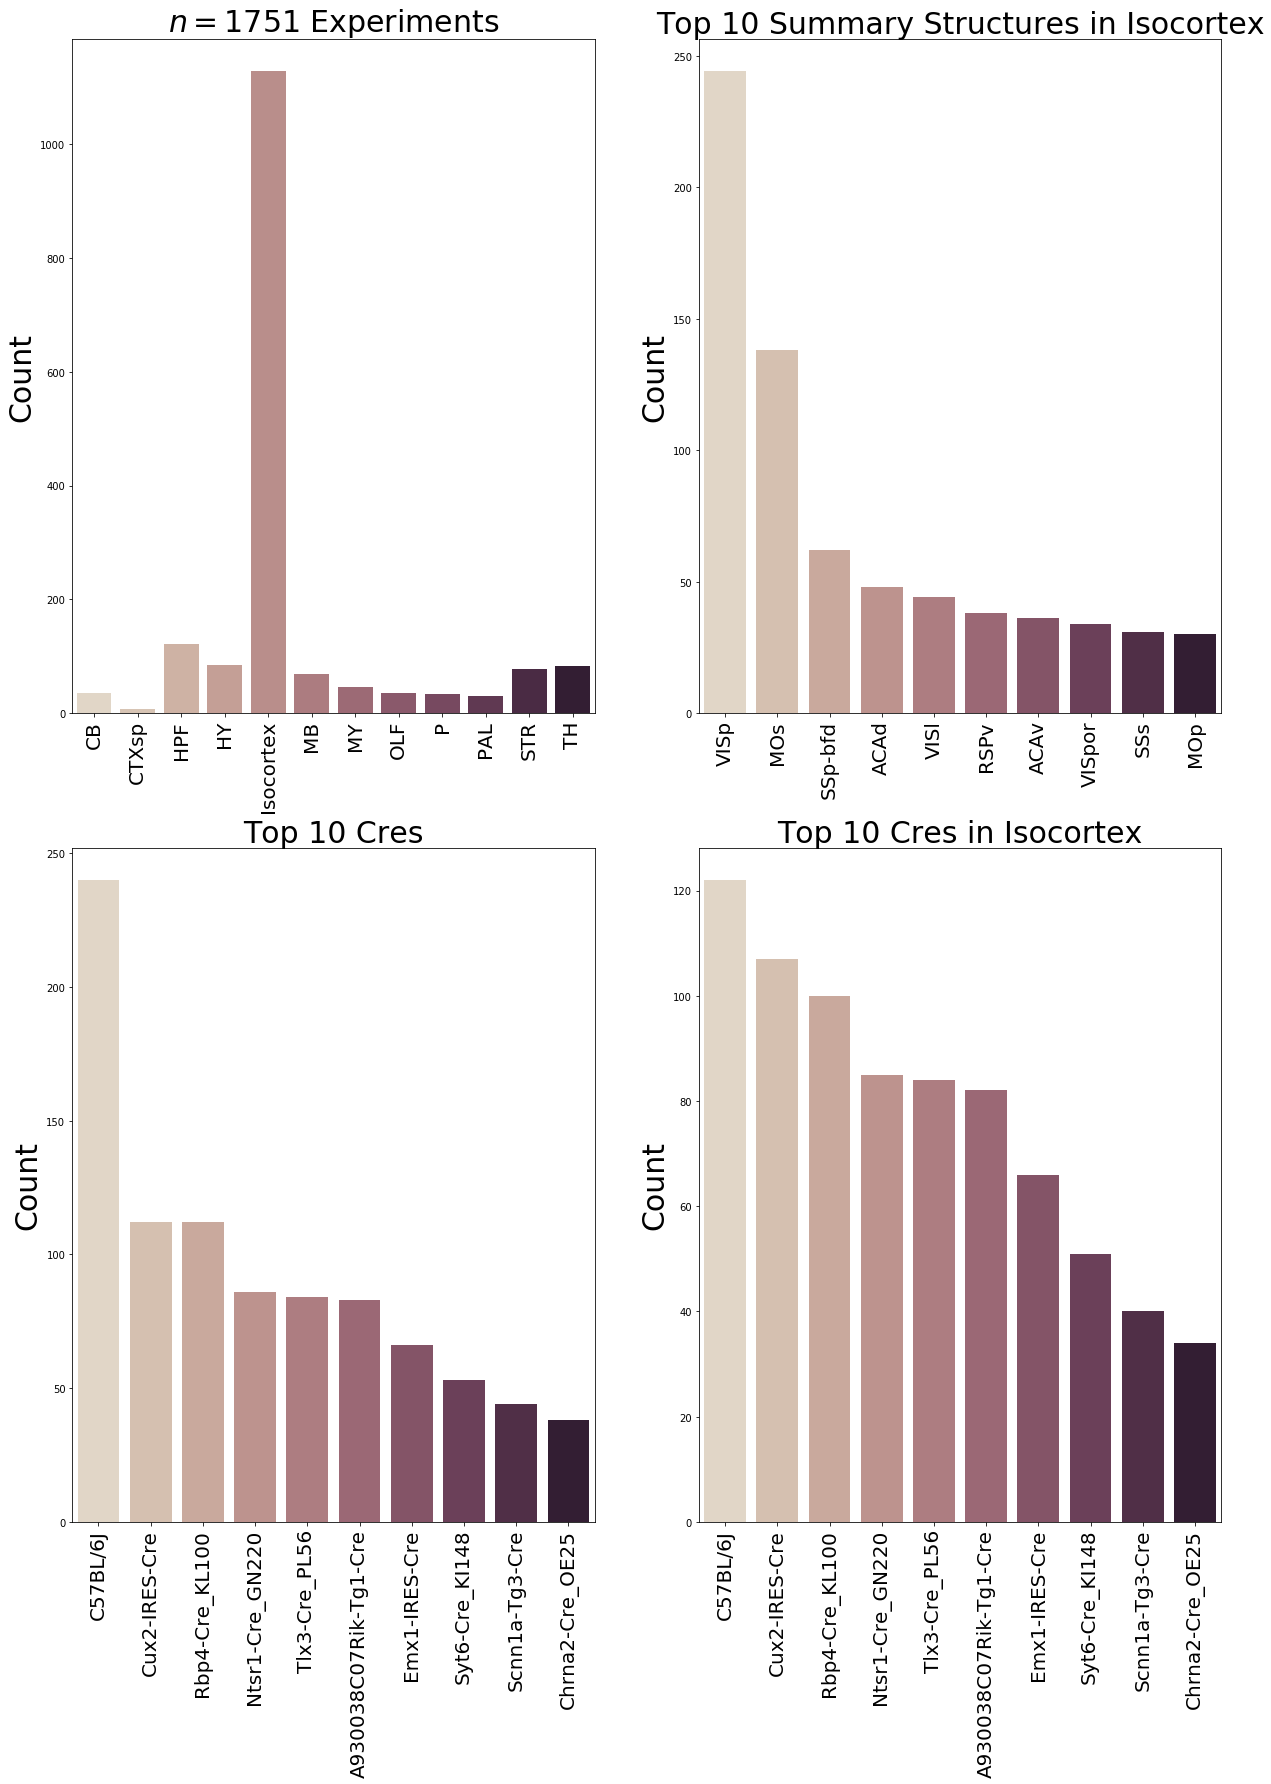

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(70, 60))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

#fig.add_subplot(ax)


i = 4
expd = pd.DataFrame([])
for sid in major_structure_ids:
    nexp = leafs[sid].shape[0]
    #print(nexp)
    for i in range(nexp):
        #print(ia_map[connectivity_data.structure_datas[sid].summary_structures[i]])
        expd = expd.append(pd.DataFrame([ia_map[sid],
                                         ia_map[connectivity_data.structure_datas[sid].summary_structures[i]], 
                                         connectivity_data.creline[sid][i]]).transpose())

isoind = np.where(np.asarray(expd[0]) == 'Isocortex')[0]
expd_iso = expd.iloc[isoind]
i = 4
inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=outer[i], wspace=.2, hspace=0.2)

ax1 = plt.Subplot(fig, inner[0], aspect='auto')
sns.catplot(x=0, kind="count", palette="ch:.25", data=expd, ax = ax1)
ax1.set_title(r'$n = 1751$ Experiments', fontsize = 30)
ax1.set_ylabel('Count', fontsize = 30)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 20)
ax1.set_xlabel('', fontsize = 30)
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax1, aspect='auto')


ax2 = plt.Subplot(fig, inner[1], aspect='auto')
#sns.catplot(x=1, kind="count", palette="ch:.25", data=expd_iso, ax = ax2)
sns.catplot(x=1, kind="count", palette="ch:.25", data=expd_iso, ax = ax2,order=expd_iso[1].value_counts().iloc[:10].index)
ax2.set_title('Top 10 Summary Structures in Isocortex', fontsize = 30)
ax2.set_ylabel('Count', fontsize = 30)
ax2.set_xlabel('', fontsize = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize = 20)
#ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax2, aspect='auto')

ax3 = plt.Subplot(fig, inner[2], aspect='auto')
sns.catplot(x=2, kind="count", palette="ch:.25", data=expd, ax = ax3,order=expd[2].value_counts().iloc[:10].index)
ax3.set_title('Top 10 Cres', fontsize = 30)
ax3.set_ylabel('Count', fontsize = 30)
ax3.set_xlabel('', fontsize = 30)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, fontsize = 20)
#ax3.set_yticklabels(ax3.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax3, aspect='auto')


ax4 = plt.Subplot(fig, inner[3], aspect='auto')
sns.catplot(x=2, kind="count", palette="ch:.25", data=expd_iso, ax = ax4,order=expd_iso[2].value_counts().iloc[:10].index)
ax4.set_title('Top 10 Cres in Isocortex', fontsize = 30)
ax4.set_ylabel('Count', fontsize = 30)
ax4.set_xlabel('', fontsize = 30)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, fontsize = 20)
#ax4.set_yticklabels(ax4.get_yticklabels(), fontsize = 15)
fig.add_subplot(ax4, aspect='auto')
#fig.subplots_adjust(wspace=1.)

#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


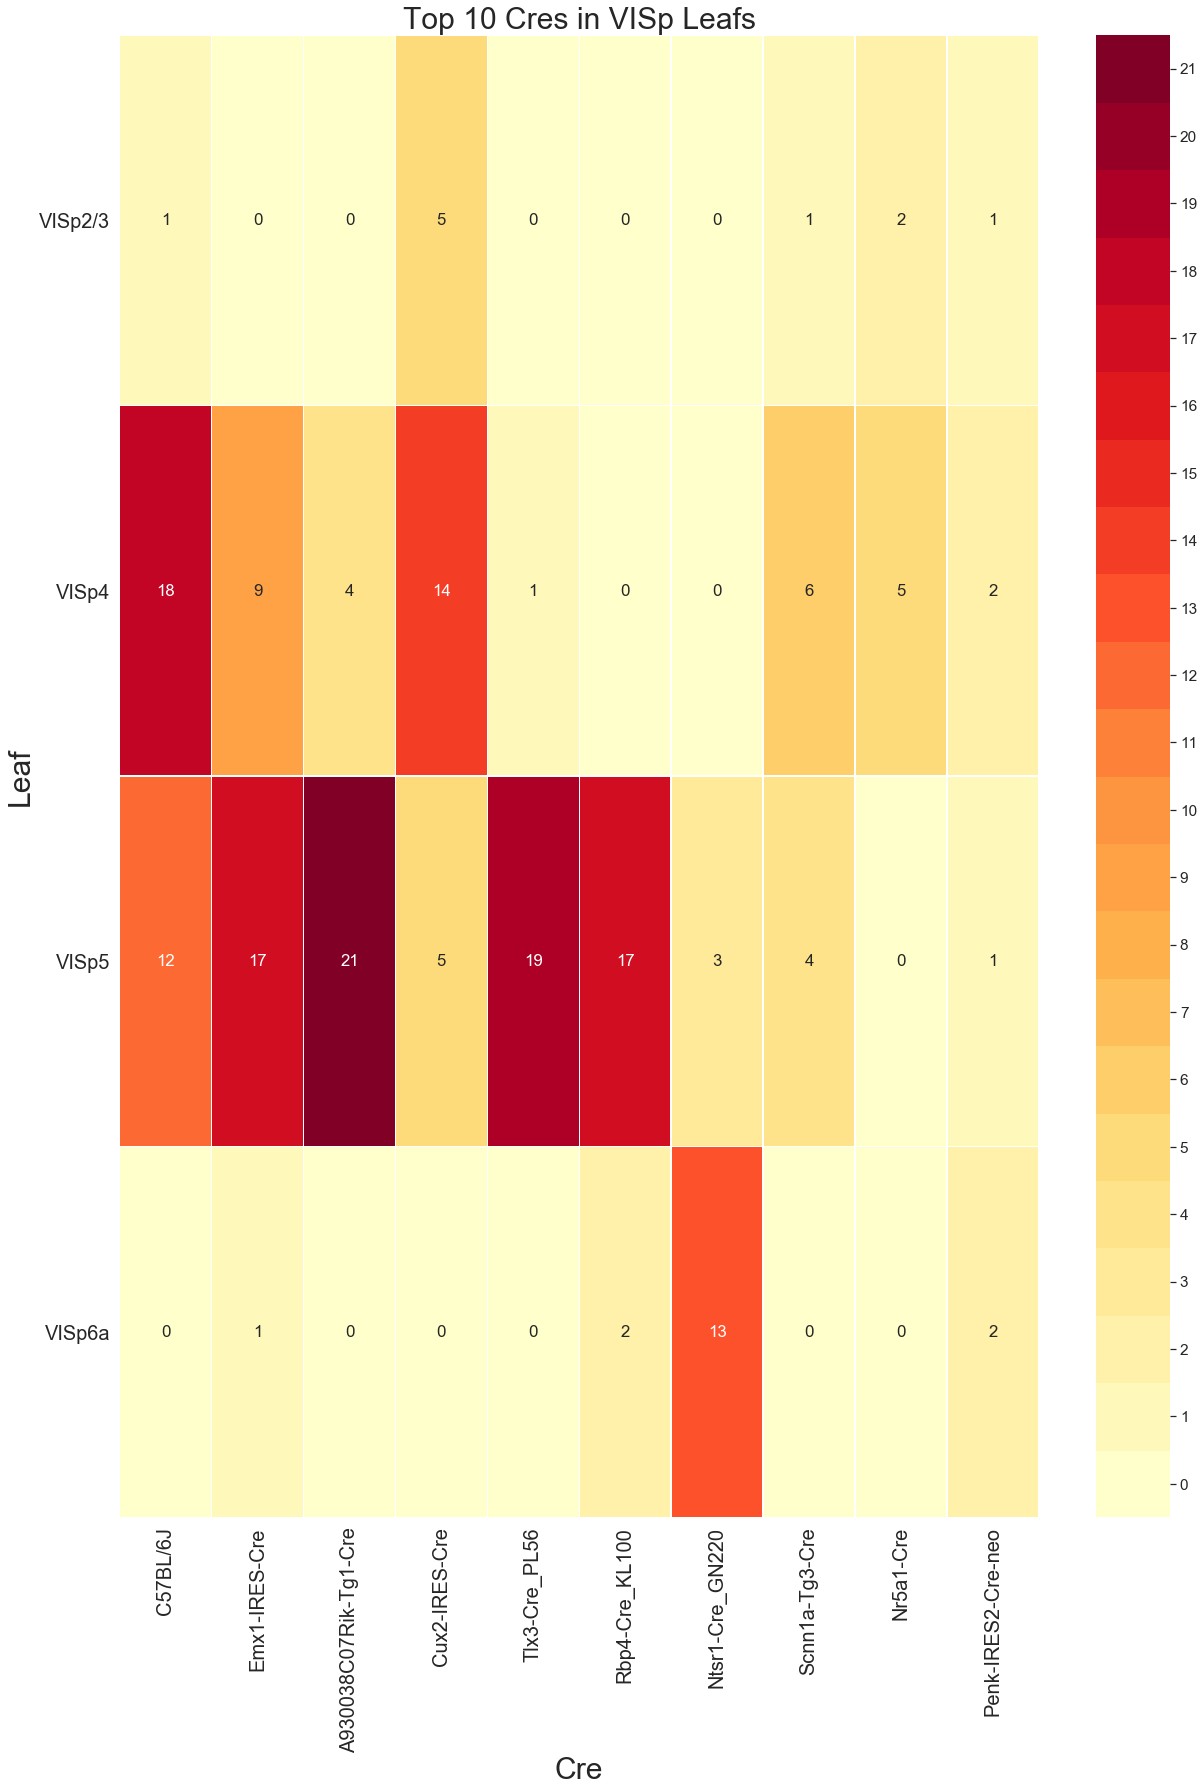

In [78]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(70, 60))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

#fig.add_subplot(ax)


i = 5
ax = fig.add_subplot(2, 3, 6)
# sns.heatmap(revels, annot=True, linewidths=0.4, cmap=cmap,
#         cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)

sns.set(font_scale=1.4)
sns.heatmap(rts, annot=True, linewidths=0.4, cmap=cmap,
        cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 20)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize = 20)
ax.set_xlabel('Cre', fontsize = 30)
ax.set_ylabel('Leaf', fontsize = 30)
ax.set_title('Top 10 Cres in VISp Leafs', fontsize = 30)

#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

In [48]:
from mcmodels.core import Mask

In [49]:
m = 4
sid = major_structure_ids[m]
source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
source_key = source_mask.get_key(structure_ids=ontological_order_leaves)
source_regions, source_counts = nonzero_unique(source_key, return_counts=True)


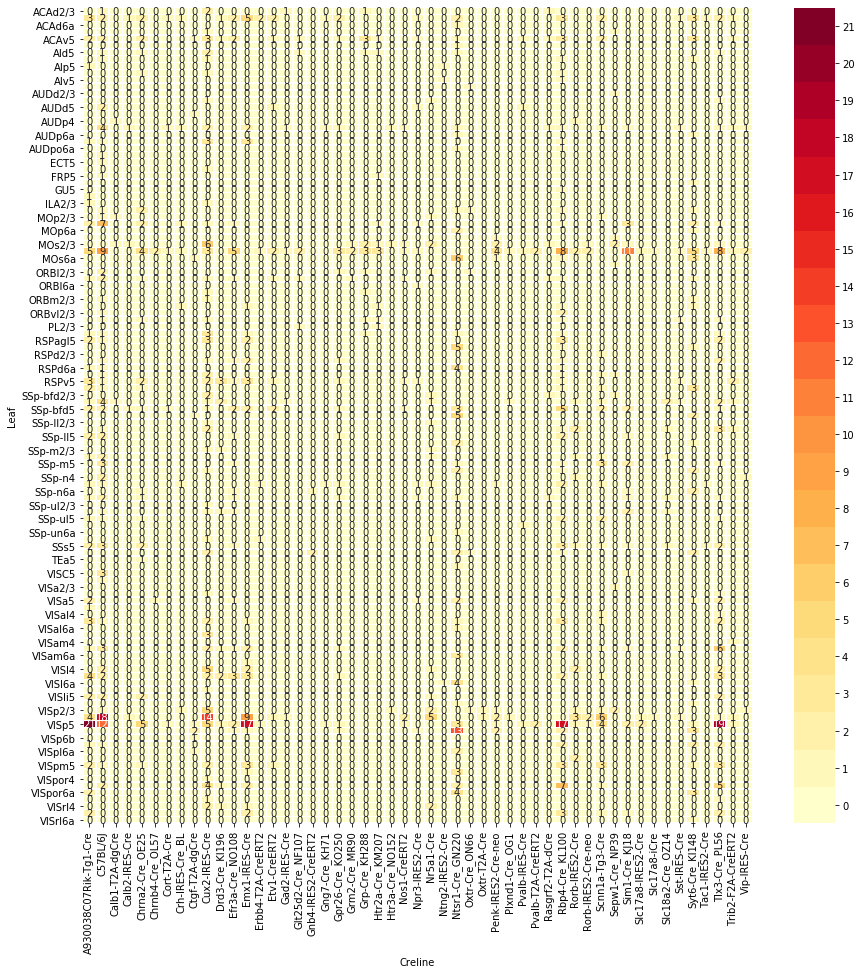

In [52]:
ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
crs = connectivity_data.creline[sid]
df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
df.columns = np.asarray(['Leaf', 'Creline','present'])
a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
a = a.fillna(0)
revels = a
ticks=np.arange(revels.values.min(),revels.values.max()+1 )
boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
cmap = plt.get_cmap("YlOrRd", revels.values.max()-revels.values.min()+1)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(revels, annot=True, linewidths=0.4, cmap=cmap,
        cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)

In [58]:
np.asarray(['VISp1','VISp2/3','VISp4' ,'VISp5' ,'VISp6a' , 'VISp6b' ])

array(['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'],
      dtype='<U7')

In [60]:
revels.loc[np.asarray(['VISp2/3','VISp4' ,'VISp5' ,'VISp6a'  ])]

Creline,A930038C07Rik-Tg1-Cre,C57BL/6J,Calb1-T2A-dgCre,Calb2-IRES-Cre,Chrna2-Cre_OE25,Chrnb4-Cre_OL57,Cort-T2A-Cre,Crh-IRES-Cre_BL,Ctgf-T2A-dgCre,Cux2-IRES-Cre,...,Sim1-Cre_KJ18,Slc17a8-IRES2-Cre,Slc17a8-iCre,Slc18a2-Cre_OZ14,Sst-IRES-Cre,Syt6-Cre_KI148,Tac1-IRES2-Cre,Tlx3-Cre_PL56,Trib2-F2A-CreERT2,Vip-IRES-Cre
Leaf,,,,,,,,,,,,,,,,,,,,,
VISp2/3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
VISp4,4.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
VISp5,21.0,12.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,5.0,...,2.0,2.0,0.0,0.0,0.0,1.0,0.0,19.0,1.0,0.0
VISp6a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [68]:
tops = np.argsort(-np.sum(revels.loc[np.asarray(['VISp2/3','VISp4' ,'VISp5' ,'VISp6a'  ])], axis = 0))[:10]

In [70]:
rts = revels.loc[np.asarray(['VISp2/3','VISp4' ,'VISp5' ,'VISp6a'  ])].iloc[:,tops]

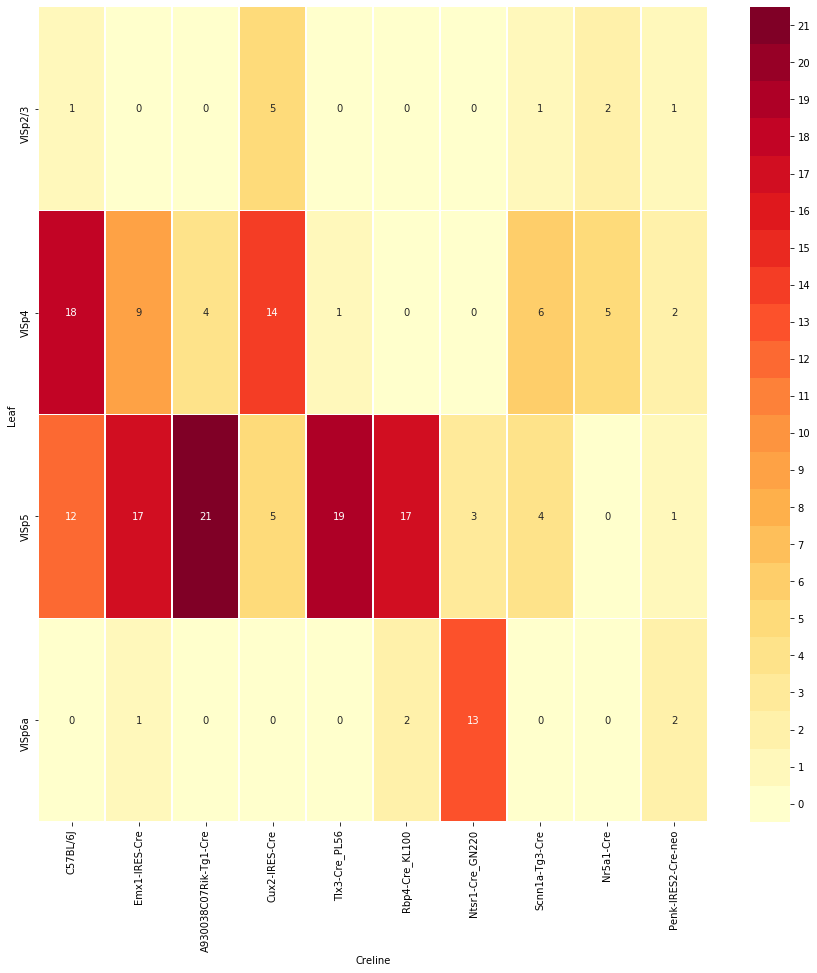

In [71]:
ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
crs = connectivity_data.creline[sid]
df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
df.columns = np.asarray(['Leaf', 'Creline','present'])
a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
a = a.fillna(0)
revels = a
ticks=np.arange(revels.values.min(),revels.values.max()+1 )
boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
cmap = plt.get_cmap("YlOrRd", revels.values.max()-revels.values.min()+1)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(rts, annot=True, linewidths=0.4, cmap=cmap,
        cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)

In [51]:
revels

Creline,A930038C07Rik-Tg1-Cre,C57BL/6J,Calb1-T2A-dgCre,Calb2-IRES-Cre,Chrna2-Cre_OE25,Chrnb4-Cre_OL57,Cort-T2A-Cre,Crh-IRES-Cre_BL,Ctgf-T2A-dgCre,Cux2-IRES-Cre,...,Sim1-Cre_KJ18,Slc17a8-IRES2-Cre,Slc17a8-iCre,Slc18a2-Cre_OZ14,Sst-IRES-Cre,Syt6-Cre_KI148,Tac1-IRES2-Cre,Tlx3-Cre_PL56,Trib2-F2A-CreERT2,Vip-IRES-Cre
Leaf,,,,,,,,,,,,,,,,,,,,,
ACAd2/3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACAd5,3.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,1.0,0.0
ACAd6a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACAv2/3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACAv5,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VISpor6a,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
VISrl2/3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
VISrl4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for m in range(len(major_structure_ids)):
#    m = 0 
    #print(m)
    sid = major_structure_ids[m]
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=ontological_order_leaves)
    source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

#    injs = msvds_leaf[sid].reg_inj_vcount_norm
#    injr = np.reshape(injs, injs.shape[0]*injs.shape[1]) #first injes[0], then injs[1]
    nexp = connectivity_data.structure_datas[sid].reg_inj.shape[0]
#    leaf = np.tile(source_regions, nexp)#np.tile(source_regions, injs.shape[0])
#    cree = np.repeat(creline[sid], injs.shape[1])

#     ls = [ia_map[leaf[i]] for i in range(len(leaf))]
#     crs = cree
#     df = pd.DataFrame(np.asarray([ls, crs, injr]).transpose())
#     df.columns = np.asarray(['leaf', 'creline','inj'])
#     df['inj'] = np.asarray(df['inj'], dtype = float)
#     a = df.pivot_table(values='inj',index='leaf',columns='creline',aggfunc=np.mean)

#     fig, ax = plt.subplots(1,figsize = (50,50))
#     sns.heatmap(a, vmax = .001,ax = ax)
#     plt.title(str(major_structures[m]) + ' injection density')
#     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' injection density')
    
    ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
    crs = connectivity_data.creline[sid]
    df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
    df.columns = np.asarray(['Leaf', 'Creline','present'])
    a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
    a = a.fillna(0)
    revels = a
    ticks=np.arange(revels.values.min(),revels.values.max()+1 )
    boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
    cmap = plt.get_cmap("YlOrRd", revels.values.max()-revels.values.min()+1)
    fig, ax = plt.subplots(figsize = (15,15))
    sns.heatmap(revels, annot=True, linewidths=0.4, cmap=cmap,
            cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)
    #plt.tight_layout()
    #plt.show()
    #plt.title(major_structures[m])
    #plt.title(major_structures[m])
    ax.set_title(str(major_structures[m]))
    fig.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid densityoct12')
    
#     fig, ax = plt.subplots(1,figsize = (50,50))
#     sns.heatmap(a, ax = ax)
#     plt.title(str(major_structures[m]) + ' centroid density')
#     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid density2')
    
    #plt.xlabel(fontsize = 15)